In [45]:
import numpy as np
from classy import Class
from Francisco import trapezoid, right_rectangle, factors, xy_values,xy_values_old
import scipy.interpolate as sp
import matplotlib.pyplot as plt
import os
import pprint


import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import ODEsolver as solve
from run import g, temp, gs, gss
from run import with_spline_ODE, steps_taken
from Emma import sterile_production

In [46]:
M_sol = 1.989e30 # solar mass in kg
Mpc = 3.086e22 # Mpc in m
c=np.logspace(-11.3,-5, 40)
kvec = np.logspace(-4,np.log10(100),100)
measured_omegacdm=.1188
Sig_8 = 0.811
A_s = 2.1e-9

In [47]:
commonsettings = {
          'N_ncdm':1,
          'use_ncdm_psd_files': 1,
          'm_ncdm': 7100,
          'T_ncdm':0.7,
          'output':'mPk',
          'P_k_max_1/Mpc':100.0,
          ## The next line should be uncommented fgor higher precision (but significantly slower running)
          'ncdm_fluid_approximation':3,
          ## You may uncomment this line to get more info on the ncdm sector from Class:
          'background_verbose':1,
          'Maximum q':100
         } 

In [48]:
def ideal_sigma8 (spec_file, omega_h_h):
    NH = Class()
        #use method .set() to 
    NH.set(commonsettings)
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': 2.1e-9,
                    }

    #use method .compute() to get data for my specific 'Spec-' file
    NH.set(othersettings)
    NH.compute()

    Sigma8_value = NH.sigma8()
    print("",Sigma8_value,"")
    
    ideal_value = ((Sig_8)/(Sigma8_value))**2*(A_s)
    
    NH.struct_cleanup()
    
    return ideal_value

In [49]:
def make_Pk(spec_file, omega_h_h, dict_values):
    
    kvec = np.logspace(-4,np.log10(100),100)
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h,
                      'A_s': ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
        
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    
    
    
    values_dict = {
                    'age': NH.age(),
                    'h': NH.h(),
                    'n_s': NH.n_s(),
                    'Neff': NH.Neff(),
                    'Omega0_cdm': NH.Omega0_cdm(),
                    'Omega0_k': NH.Omega0_k(),
                    'Omega0_m': NH.Omega0_m(),
                    'Omega_b': NH.Omega_b(),
                    'omega_b': NH.omega_b(),
                    'Omega_g': NH.Omega_g(),
                    'Omega_lambda': NH.Omega_Lambda(),
                    'Omega_m': NH.Omega_m(),
                    'Omega_r': NH.Omega_r(),
                    'rs_drag': NH.rs_drag(),
                    'Sigma8': NH.sigma8(),
                    'Sigma8_cb': NH.sigma8_cb(),
                    'T_cmb': NH.T_cmb(),
                    'tau_reio': NH.tau_reio(),
                    'theta_s_100': NH.theta_s_100(),
                    'theta_star_100': NH.theta_star_100(),
                    'pk': pkNH,
                    'k':kvec
                    }
    #this method clears the commonsettings out of the set method, so that we can load a new file 
    NH.struct_cleanup() 

    #saving the dictionary that we created above to a .npz file
    np.savez( dict_values + '.npz', Class_values = values_dict)


    np.save(spec_file+ '-Pknew',np.array(pkNH))
    np.save(spec_file+'-knew',kvec)
    
    return new_sig8

In [59]:
def trap(f,x):
    integral = 0
    for i in range(1,len(f)):
        integral += 0.5 * (f[i] + f[i-1]) * (x[i] - x[i-1])
    return integral

def R(M):
    c = 2.5
    G = 6.67e-11 # m^3 / kg / s^2
    H100 = 100 * (1000/Mpc) # km/s/Mpc -> 1/s
    omegah2 = 0.1188

    rhobar = omegah2 * 3 * H100**2 / (8 * np.pi * G) / M_sol * Mpc**3 # kg / m^3 -> M_sol / Mpc^3
    return (3 * M / (4 * np.pi * rhobar * c**3))**(1/3) # Mpc

def W(k,R):
    
        if np.isscalar(k):
            if k * R > 1:
                return 0
            else:
                return 1
        else:
            result = np.zeros(len(k))
            for i in range(len(k)):
                if k[i] * R < 1 and k[i+1] * R > 1:
                    result[i] = (1 - k[i] * R)/(k[i+1]*R - k[i]*R)
                elif k[i] * R < 1:
                    result[i] = 1
            return result
        
def S(M, k_vals, Pk_vals):
        Rv = R(M)
        
        integrand = k_vals**2 * Pk_vals * W(k_vals, Rv)**2 / (2 * ( np.pi**2))
        return trap(integrand,k_vals)


def dNdlnM(M0,M,P_spline):
    Rv = R(M)
    return 1 / 44.5 / (6 * np.pi**2) * (M0 / M) / Rv**3 / np.sqrt(2 * np.pi * ( S(M, k_vals,Pk_vals) - S(M0,k_vals,Pk_vals))) * P_spline(1/Rv)

def integrating(k_vals, Pk_vals):
    M0 = 1.989e30 # M_sol in kg git 
    
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)
    
    lnM_vals = np.linspace(np.log(1e8),np.log(M0))
    
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]), k_vals, Pk_vals)- S(np.exp(lnM_vals[-1]),k_vals, Pk_vals)
    
    integrand = np.zeros(len(lnM_vals)-1)

    for i in range(len(integrand)):
        integrand[i] = dNdlnM(M0, np.exp(lnM_vals[i]), P_spline)
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals


def Bella_2(file_name, k): ##.npz as first input and step size as the second
    
    dat = np.load('Neutrino Data/' + file_name)

    omega_h_h = dat['omega_h2']
    a,b,c,d,e = xy_values(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    make_Pk(spec_file, omega_h_h, 'CLASS_Values')
    
    k_vals = np.load('Spec-knew.npy')
    Pk_vals = np.load('Spec-Pknew.npy')
    
    alpha, beta, gamma, delta = integrating(k_vals, Pk_vals)
    return alpha,beta, gamma, delta

0.0026648604811727156

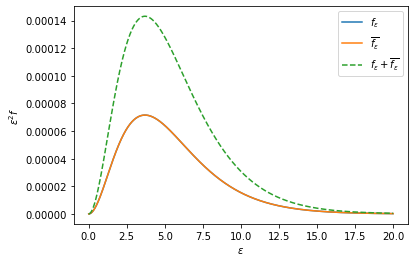

In [52]:
sterile_production(1000, 'electron', 0.0071, 10**(-10), 1e-20, make_plot=True, folder_name="Neutrino Data")

In [55]:
def file_name():
    file_str = []
    length = os.listdir('Neutrino Data/')
    for i in range(len(length)):
        curr = length[i]
        file_str.append(curr)
    return file_str


file_names = file_name()
file_name = str(file_names[2])
print(file_name)
dat = np.load('Neutrino Data/' + file_name)

electronx1e-20x1e-10.npz


In [60]:
w,x,y,z = Bella_2(file_name, 4)

 0.8194957865773755 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.11613513951882729
omega_ncdm  :  0.0026648604811727156
A_s  :  2.05668392274887e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


/Users/nu_tau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


In [37]:
print(w)   

475.5409677162169


In [38]:
file_name = 'Neutrino Data/1x0.00049x3e-09-data.npz'

def CDM_ideal_sigma8 (spec_file, omega_h_h):
    
    NH = Class()
        #use method .set() to 
    NH.set(commonsettings)
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': 2.1e-9,
                    }

    #use method .compute() to get data for my specific 'Spec-' file
    NH.set(othersettings)
    NH.compute()

    Sigma8_value = NH.sigma8()
    print("",Sigma8_value,"")
    
    ideal_value = ((Sig_8)/(Sigma8_value))**2*(A_s)
    
    NH.struct_cleanup()
    
    return ideal_value

def CDM_make_Pk(spec_file,omega_h_h):
    
    kvec = np.logspace(-4,np.log10(100),100)
    
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': CDM_ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    
    
    
    values_dict = {
                    'age': NH.age(),
                    'h': NH.h(),
                    'n_s': NH.n_s(),
                    'Neff': NH.Neff(),
                    'Omega0_cdm': NH.Omega0_cdm(),
                    'Omega0_k': NH.Omega0_k(),
                    'Omega0_m': NH.Omega0_m(),
                    'Omega_b': NH.Omega_b(),
                    'omega_b': NH.omega_b(),
                    'Omega_g': NH.Omega_g(),
                    'Omega_lambda': NH.Omega_Lambda(),
                    'Omega_m': NH.Omega_m(),
                    'Omega_r': NH.Omega_r(),
                    'rs_drag': NH.rs_drag(),
                    'Sigma8': NH.sigma8(),
                    'Sigma8_cb': NH.sigma8_cb(),
                    'T_cmb': NH.T_cmb(),
                    'tau_reio': NH.tau_reio(),
                    'theta_s_100': NH.theta_s_100(),
                    'theta_star_100': NH.theta_star_100(),
                    'pk': pkNH,
                    'k':kvec/h
                    }
    #this method clears the commonsettings out of the set method, so that we can load a new file 
    NH.struct_cleanup() 

    #saving the dictionary that we created above to a .npz file
    np.savez('PureCDM_CLASS_Values' + '.npz',Class_values = values_dict)


    np.save(spec_file+ '-PknewCDM',np.array(pkNH))
    np.save(spec_file+'-knewCDM',kvec/h)
    
    return new_sig8






def Bella_Old_Structure(file_name, k): 
    a,b,c,d,e = xy_values_old(file_name, k)
    
    dat = np.load(file_name)

    omega_h_h = dat['omega_s']
    a,b,c,d,e = xy_values_old(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    CDM_make_Pk(spec_file, omega_h_h)
    
    global k_vals
    k_vals = np.load('Spec-knew.npy')
    global Pk_vals
    Pk_vals = np.load('Spec-Pknew.npy')
    

    global M0
    M0 = 3.2e12 # M_sol / h
    global P_spline
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)


    global ln_vals
    lnM_vals = np.linspace(np.log(1e8),np.log(M0))
    
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]))- S(np.exp(lnM_vals[-1]))
    
    integrand = np.zeros(len(lnM_vals)-1)

    for i in range(len(integrand)):
        integrand[i] = dNdlnM(np.exp(lnM_vals[i]))
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals

In [39]:
alpha, beta, gamma, delta = Bella_Old_Structure(file_name, 4)

 0.7537938931744148 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.05941682610033301
omega_ncdm  :  0.05938317389966699
A_s  :  2.430836639371758e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


In [40]:
print(alpha)

475.5409677162169


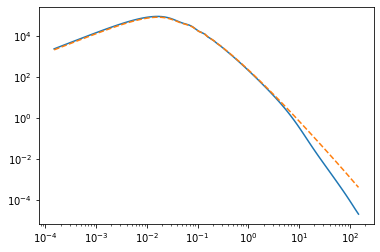

In [41]:
values = np.load('CLASS_Values.npz', allow_pickle = True)

pk = values['Class_values'].item()['pk']
k = values['Class_values'].item()['k']

cdm_values = np.load('PureCDM_CLASS_Values.npz', allow_pickle = True)

pk_cdm = cdm_values['Class_values'].item()['pk']
k_cdm = cdm_values['Class_values'].item()['k']


plt.figure()
plt.loglog(k_cdm,pk_cdm)
plt.loglog(k,pk, linestyle = '--')

In [42]:
other_values = values['Class_values'].item()
pprint.pprint(other_values)

{'Neff': 3.0460601123273072,
 'Omega0_cdm': 0.25446953251161175,
 'Omega0_k': 0.0,
 'Omega0_m': 0.308584062938724,
 'Omega_b': 0.0482754208891869,
 'Omega_g': 5.418669010249671e-05,
 'Omega_lambda': 0.6913242657047305,
 'Omega_m': 0.308584062938724,
 'Omega_r': 9.16713565455487e-05,
 'Sigma8': 0.8110000000000009,
 'Sigma8_cb': 0.8110001728342537,
 'T_cmb': 2.7255,
 'age': 13.83862734699998,
 'h': 0.67556,
 'k': array([1.48025342e-04, 1.70193172e-04, 1.95680791e-04, 2.24985358e-04,
       2.58678489e-04, 2.97417402e-04, 3.41957739e-04, 3.93168302e-04,
       4.52048006e-04, 5.19745357e-04, 5.97580860e-04, 6.87072774e-04,
       7.89966729e-04, 9.08269772e-04, 1.04428952e-03, 1.20067919e-03,
       1.38048929e-03, 1.58722722e-03, 1.82492560e-03, 2.09822098e-03,
       2.41244425e-03, 2.77372465e-03, 3.18910932e-03, 3.66670075e-03,
       4.21581483e-03, 4.84716260e-03, 5.57305910e-03, 6.40766369e-03,
       7.36725615e-03, 8.47055429e-03, 9.73907906e-03, 1.11975743e-02,
       1.28744894

In [43]:
CDM_values = cdm_values['Class_values'].item()
pprint.pprint(CDM_values)

{'Neff': 3.047211589135166,
 'Omega0_cdm': 0.13019118953763625,
 'Omega0_k': 0.0,
 'Omega0_m': 0.30858406293872165,
 'Omega_b': 0.0482754208891869,
 'Omega_g': 5.418669010249671e-05,
 'Omega_lambda': 0.6913242657047305,
 'Omega_m': 0.30858406293872165,
 'Omega_r': 9.167135654788687e-05,
 'Sigma8': 0.8109999999999995,
 'Sigma8_cb': 0.8633479445783233,
 'T_cmb': 2.7255,
 'age': 13.838627346887229,
 'h': 0.67556,
 'k': array([1.48025342e-04, 1.70193172e-04, 1.95680791e-04, 2.24985358e-04,
       2.58678489e-04, 2.97417402e-04, 3.41957739e-04, 3.93168302e-04,
       4.52048006e-04, 5.19745357e-04, 5.97580860e-04, 6.87072774e-04,
       7.89966729e-04, 9.08269772e-04, 1.04428952e-03, 1.20067919e-03,
       1.38048929e-03, 1.58722722e-03, 1.82492560e-03, 2.09822098e-03,
       2.41244425e-03, 2.77372465e-03, 3.18910932e-03, 3.66670075e-03,
       4.21581483e-03, 4.84716260e-03, 5.57305910e-03, 6.40766369e-03,
       7.36725615e-03, 8.47055429e-03, 9.73907906e-03, 1.11975743e-02,
       1.287

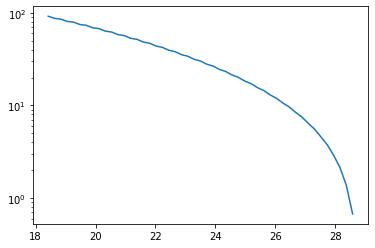

[91.73468365 86.96908111 85.34345465 80.69561042 79.20139978 74.67509246
 73.22974498 68.90521538 67.45091014 63.38490871 61.92794577 58.11094442
 56.65656496 53.07794465 51.63150805 48.28593639 46.85355898 43.73162681
 42.31840968 39.41247931 38.02424056 35.32830065 33.97028403 31.47513756
 30.15210816 27.85045201 26.56682084 24.44969631 23.20912563 21.26753577
 20.07350724 18.29891852 17.15395008 15.53644971 14.44298119 12.97401822
 11.9339205  10.60427444  9.61885414  8.41947507  7.48996733  6.4124873
  5.53934894  4.57491785  3.75852669  2.89910362  2.13933467  1.37683568
  0.67326559]
[4.74388116e+02 3.86396186e+02 3.09481144e+02 2.52412612e+02
 2.02120622e+02 1.64993952e+02 1.32085161e+02 1.07860603e+02
 8.63582909e+01 7.05057073e+01 5.64508842e+01 4.60828642e+01
 3.69182784e+01 3.01542431e+01 2.41633909e+01 1.97258248e+01
 1.58071433e+01 1.29062157e+01 1.03485010e+01 8.45058090e+00
 6.77600168e+00 5.53059084e+00 4.43631989e+00 3.62246308e+00
 2.90744130e+00 2.37406738e+00 1.9066

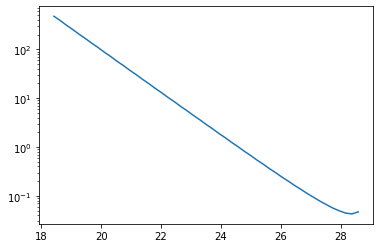

475.5409677162169


In [44]:
plt.figure()
plt.semilogy(z[:-1],y)
plt.show()
print(y)


for i in range(len(x)):
    x[i] = dNdlnM(np.exp(z[i]))
    
    
print(x)


print(w)
plt.figure()
plt.semilogy(z[:-1],x)
plt.show()    



print(w) 